In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab
from torchtext.data import get_tokenizer
from torchtext.datasets import SST2
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import nlpaug.augmenter.word as naw

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%run models/RNN.ipynb

In [45]:
train_iter = SST2(split="train")
val_iter = SST2(split="dev")
# test_iter = SST2(split="test")

tokenizer = get_tokenizer('spacy')
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocabulary = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [46]:
def yield_tokens_adv(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocabulary = build_vocab_from_iterator(yield_tokens_adv(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [47]:
glove_vectors = vocab.GloVe(name='6B', dim=100)
vocabulary.vectors = glove_vectors.get_vecs_by_tokens(vocabulary.get_itos())

In [48]:
BATCH_SIZE = 128
MAX_VOCAB_SIZE = 400000
aug = naw.AntonymAug()

def collate(x):
    batch = []
    for item in x:
        seq = []
        for word in tokenizer(item[0]):
            seq.append(vocabulary[word])
        batch.append(torch.tensor(seq))
    l = torch.tensor([item[1] for item in x]).unsqueeze(dim=1)
    return nn.utils.rnn.pad_sequence(batch, padding_value=vocabulary["<pad>"], batch_first=True), l

def collate_adv(x):
    batch = []
    for item in x:
        seq = []
        sentence = aug.augment(item[0])[0]
        for word in tokenizer(sentence):
            seq.append(vocabulary[word])
        batch.append(torch.tensor(seq))
    l = torch.tensor([item[1] for item in x]).unsqueeze(dim=1)
    return nn.utils.rnn.pad_sequence(batch, padding_value=vocabulary["<pad>"], batch_first=True), l

In [49]:
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn= lambda x : collate(x), drop_last=True)
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn= lambda x : collate(x), drop_last=True)
val_adv_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn= lambda x : collate_adv(x))

In [50]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 2

model = RNN(vocabulary, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 40,802 trainable parameters



## Train the Model

In [52]:
optimizer = optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss().to(device)
model = model.to(device).float()
criterion = criterion.to(device)

In [53]:
def binary_accuracy(preds, y):
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [54]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    c= 0
    for inputs, labels in iterator:
        c+=1
        inputs = inputs.to(device)
        labels = labels.view(-1).to(device)
        optimizer.zero_grad()
        predictions, _ = model(inputs)
        predictions = predictions.float()
        loss = criterion(predictions, F.one_hot(labels, num_classes=2).float())
        acc = binary_accuracy(predictions.argmax(-1), labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / c, epoch_acc / c

In [55]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    c = 0
    model.eval()

    with torch.no_grad():
        for inputs,labels in iterator:
            c+=1
            inputs = inputs.to(device)
            labels = labels.view(-1).to(device)
            predictions, _ = model(inputs)
            predictions = predictions.float()
            loss = criterion(predictions, F.one_hot(labels, num_classes=2).float())
            acc = binary_accuracy(predictions.argmax(-1), labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / c, epoch_acc / c

In [56]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [57]:
from tqdm import tqdm

N_EPOCHS = 20

best_valid_loss = float('inf')

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/rnn.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.597 | Train Acc: 66.10%
	 Val. Loss: 0.644 |  Val. Acc: 58.72%
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.601 | Train Acc: 64.51%
	 Val. Loss: 0.631 |  Val. Acc: 61.20%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.593 | Train Acc: 65.22%
	 Val. Loss: 0.631 |  Val. Acc: 61.72%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.585 | Train Acc: 65.79%
	 Val. Loss: 0.588 |  Val. Acc: 64.84%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.561 | Train Acc: 67.12%
	 Val. Loss: 0.581 |  Val. Acc: 65.23%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.552 | Train Acc: 67.58%
	 Val. Loss: 0.593 |  Val. Acc: 65.23%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.547 | Train Acc: 67.96%
	 Val. Loss: 0.576 |  Val. Acc: 63.80%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.548 | Train Acc: 67.77%
	 Val. Loss: 0.593 |  Val. Acc: 63.67%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.545 | Train Acc: 70.66%
	 Val. Loss: 0.547 |  Val. Acc: 72.66%
Epoch: 10 | Epoch T

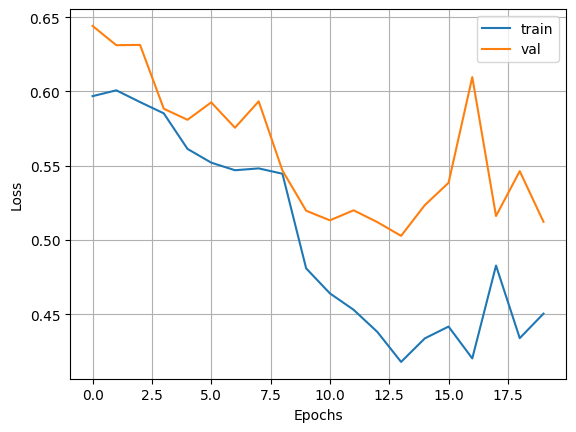

In [58]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

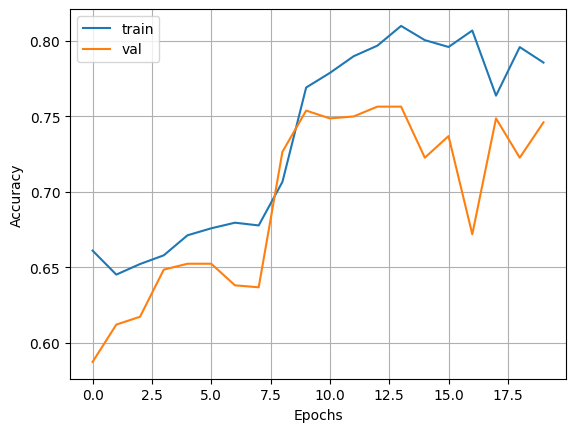

In [59]:
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

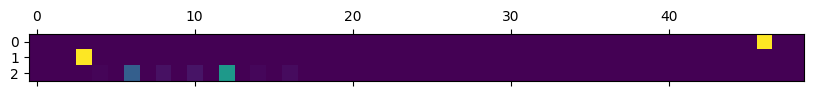

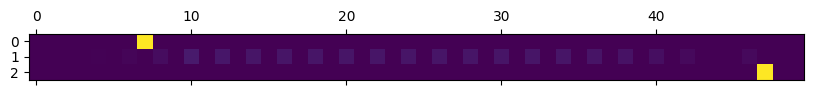

In [47]:
def plot_attention(model, iterator):
    model.eval()

    with torch.no_grad():
        for inputs,labels in iterator:
            inputs = inputs.to(device)
            labels = labels.view(-1).to(device)
            predictions, attention = model(inputs)
            # print(attention.shape, predictions.shape)
            fig = plt.figure(figsize=(10, 10)) # [batch_size, n_step]
            ax = fig.add_subplot(1, 1, 1)
            ax.matshow(attention[:3], cmap='viridis')
            break
plot_attention(model, val_loader)
plot_attention(model, val_adv_loader)

In [93]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go

def display_pca_scatterplot_3D(topn=-1):

    # if words == None:
    #     if sample > 0:
    #         words = np.random.choice(list(vocab.get_stoi().keys()), sample)
    #     else:
    #         words = [ word for word in vocab ]
    #
    # word_vectors = np.array([vocab[w] for w in words])
    # print(word_vectors.shape)
    xs = []
    for batch in val_adv_loader:
        inputs, _ = batch
        inputs = inputs.to(device)
        embs = net.embedding(inputs).view(-1, 100)
        # print(embs.shape)
        xs.append(embs)
    word_vectors = torch.cat(xs, dim=0).cpu().detach().numpy()
    three_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:3]
    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:2]
    data = []
    trace_input = go.Scatter3d(
        x = three_dim[:topn,0],
        y = three_dim[:topn,1],
        z = three_dim[:topn,2]
    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)

    data.append(trace_input)

    # Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
            x=1,
            y=0.5,
            font=dict(
                family="Courier New",
                size=25,
                color="black"
            )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
    )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()

In [97]:

display_pca_scatterplot_3D(topn=1000)

(39776, 3)
